In [1]:
import os
os.chdir('..')

# Packages

In [2]:
import datetime
data_datetime = datetime.datetime(2020, 5, 28)

In [3]:
from nlp import preprocessing

In [4]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import TruncatedSVD # SVD for sparse matrices
from sklearn.preprocessing import normalize # normalization for sparse matrices


# Functions

In [5]:
dpi = 300

# Read in Small Data (metadata)

In [6]:
x = pd.read_csv('big_data/metadata_20-05-28.csv')
print(len(x))
del x

C:\Users\vldoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


137326


In [7]:
metadata = pd.read_csv('big_data/metadata_20-05-28.csv')
print(len(metadata))
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)
print(len(metadata))

137326
107557


Using the search query to focus on abstracts:
**"COVID-19"** OR Coronavirus OR "Corona virus" OR **"2019-nCoV"** OR "SARS-CoV" OR "MERS-CoV" OR “Severe Acute Respiratory Syndrome” OR “Middle East Respiratory Syndrome” 

In [8]:
metadata = metadata[metadata['abstract'].str.lower().str.contains(
 "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome|sars-cov-2") | 
     metadata['abstract'].str.contains("MERS")
     ]
print(len(metadata))

35281


In [9]:
count = sum(metadata['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2'))
print('There are ' + str(count) + ' articles mentioning COVID.')

There are 18412 articles mentioning COVID.


In [10]:
covid_article_indexes = np.argwhere(np.array(metadata['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2'))).T[0]
mers_article_indexes = np.argwhere(np.array(metadata['abstract'].str.contains('MER|middle east| Middle East'))).T[0]
sars_article_indexes = np.argwhere(np.array(metadata['abstract'].str.contains('SARS'))).T[0]

# Traditional ML

## Preprocessing

Preprocess text

In [11]:
t = time.time()
preprocessor = preprocessing.Preprocessor(metadata['abstract'])
preprocessor.preprocess(lemmatize=True, stopwords=['abstract'], min_token_length=3)
print(time.time() - t)

204.53879189491272


Preprocess for bigrams

In [12]:
preprocessor.get_bigrams_from_preprocessed()

Create key NLP objects for word counts

In [13]:
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)

0 activ
1 antigen
2 basi
3 bind
4 bind_neisseria
5 ceacam
6 ceacam_homophil
7 compos
8 crystal_structur
9 discuss
10 domain

 180896 unique words. 

69647 unique words after extremes filtered. 


Word 31 ("report") appears 1 time.
Word 37 ("uniqu") appears 1 time.
Word 83 ("studi") appears 1 time.
Word 100 ("analysi") appears 1 time.
Word 131 ("health_care") appears 3 time.
Word 133 ("high") appears 1 time.
Word 138 ("infect") appears 1 time.
Word 151 ("possibl") appears 1 time.
Word 158 ("relat") appears 1 time.
Word 160 ("respiratori_syndrom") appears 1 time.
Word 164 ("sar") appears 1 time.
Word 170 ("sever_acut") appears 1 time.
Word 178 ("taiwan") appears 1 time.
Word 186 ("worker") appears 2 time.
Word 225 ("outbreak") appears 2 time.
Word 242 ("suffer") appears 1 time.
Word 323 ("factor") appears 1 time.
Word 374 ("emerg") appears 1 time.
Word 690 ("investig") appears 1 time.
Word 814 ("discontinu") appears 1 time.
Word 894 ("hospit") appears 2 time.
Word 914 ("set") appears 1 t

## PCA

## Implementation

In [14]:
# tfidf_sparse_norm = normalize(tfidf_sparse, norm='l1', axis=1)

[0.00259446 0.00816024 0.00529798 0.00514303 0.00427656 0.00367085
 0.00341933 0.00319238 0.00302529 0.00276143 0.00253068 0.00247699
 0.00242049 0.00234551 0.0020477  0.00201071 0.00193428 0.00187215
 0.00182246 0.00174498 0.00172552 0.00164005 0.00158073 0.00156899
 0.00147814 0.00145746 0.00140777 0.00138696 0.00134964 0.00133231]


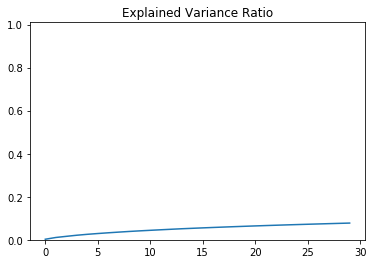

In [15]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)
# pca = PCA(n_components = 100, svd_solver = 'randomized', random_state = 20)

# transformed = truncatedsvd.fit_transform(tfidf_sparse_norm)
transformed = truncatedsvd.fit_transform(tfidf_sparse)


plt.title('Explained Variance Ratio')
plt.plot(np.cumsum(truncatedsvd.explained_variance_ratio_)[0:30])
plt.ylim(0, 1.01)
print(truncatedsvd.explained_variance_ratio_)

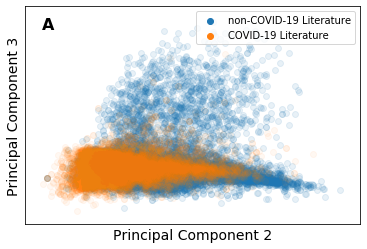

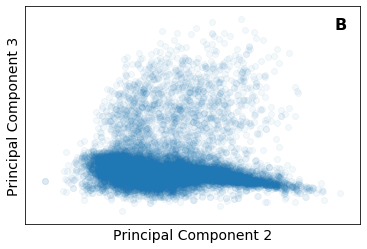

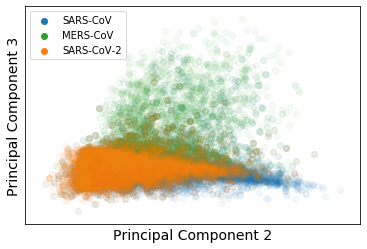

In [19]:
xscale_log_addition = 0.1
c_0, c_1 = 1, 2
#===== Set boundaries to remove outliers
f = 0.01 # dimension factor
p = 0.5 #percentile
width = np.percentile(transformed[:,c_0], 100 - p) - np.percentile(transformed[:,c_0], p)
height = np.percentile(transformed[:,c_1], 100 - p) - np.percentile(transformed[:,c_1], p)

left, right = np.percentile(transformed[:,c_0], p) - f * width, np.percentile(transformed[:,c_0], 100 - p) + f * width
low, high = np.percentile(transformed[:,c_1], p) - f * height, np.percentile(transformed[:,c_1], 100 - p) + f * height
#=====

fig, ax = plt.subplots()
not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,c_0],
            transformed[not_covid,c_1], alpha=0.1, label='non-COVID-19 Literature')

plt.scatter(transformed[covid_article_indexes,c_0],
            transformed[covid_article_indexes,c_1], alpha=0.05, label='COVID-19 Literature')
# plt.xlim(left, right); plt.ylim(low, high)
# plt.title('COVID-19 and Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component ' + str(c_0 + 1), size=14)
plt.ylabel('Principal Component ' + str(c_1 + 1), size=14)
plt.xticks([]); plt.yticks([])
leg=plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.text(0.05, 0.95, 'A', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
# fig.savefig('Paper/Figures/2a.png', dpi=dpi)
plt.show()



fig, ax = plt.subplots()
not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,c_0],
            transformed[not_covid,c_1], alpha=0.05, label='non-COVID-19 Literature')
# plt.title('Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component ' + str(c_0 + 1), size=14)
plt.ylabel('Principal Component ' + str(c_1 + 1), size=14)
plt.xticks([]); plt.yticks([])
# plt.xlim(left, right); plt.ylim(low, high)
# plt.legend()
plt.text(0.925, 0.95, 'B', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
# fig.savefig('Paper/Figures/2b.png', dpi=dpi)
plt.show()


fig, ax = plt.subplots()
plt.scatter(transformed[sars_article_indexes,c_0],
            transformed[sars_article_indexes,c_1], alpha=0.05, label='SARS-CoV', zorder=1)
plt.scatter(transformed[mers_article_indexes,c_0],
            transformed[mers_article_indexes,c_1], alpha=0.05, label='MERS-CoV', c='C2', zorder=2)
plt.scatter(transformed[covid_article_indexes,c_0],
            transformed[covid_article_indexes,c_1], alpha=0.05, label='SARS-CoV-2', c='C1', zorder=3)
# plt.title('Literature of Various Diseases', size=18)
plt.xlabel('Principal Component ' + str(c_0 + 1), size=14)
plt.ylabel('Principal Component ' + str(c_1 + 1), size=14)
plt.xticks([]); plt.yticks([])
leg=plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# plt.xlim(left, right); plt.ylim(low, high)
# fig.savefig('Paper/Figures/3.png', dpi=dpi)
plt.show()

Identifying PCs that separate COVID/non-COVID literature

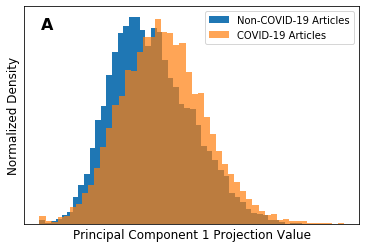

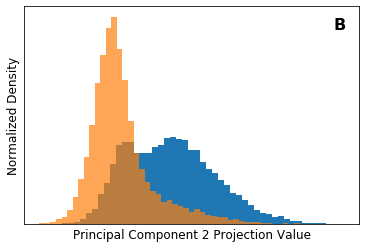

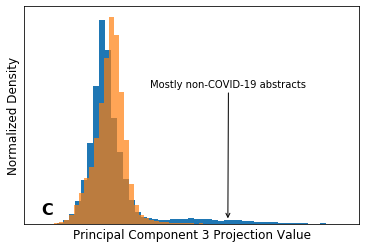

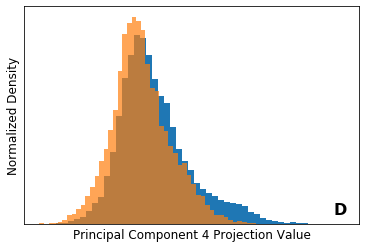

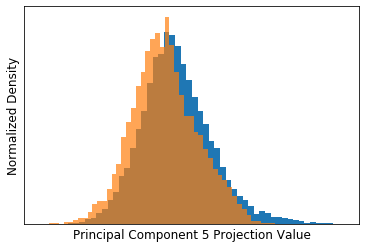

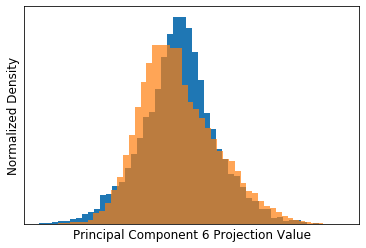

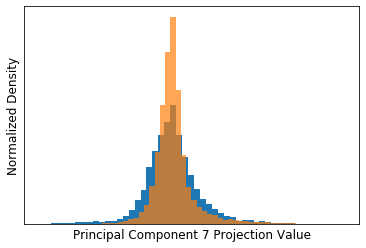

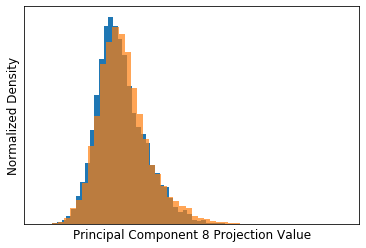

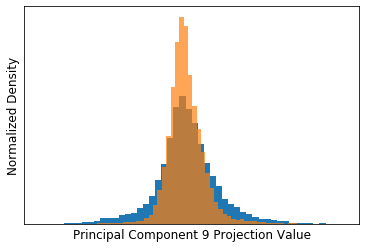

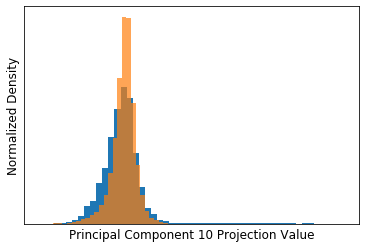

In [73]:
n_bins = 50

panel_set = [
    [0.05, 0.95, 'A'],
    [0.925, 0.95, 'B'],
    [0.05, 0.1, 'C'],
    [0.925, 0.1, 'D']
]


for c in range(10):
    fig, ax = plt.subplots()
    _, _, _ = plt.hist(transformed[np.setdiff1d(list(range(len(transformed))), covid_article_indexes), c]
             , density=True, alpha=1., bins=50, label='Non-COVID-19 Articles')
    _, _, _ = plt.hist(transformed[covid_article_indexes, c], density=True,
                       alpha=0.7, bins=50, label='COVID-19 Articles') 
#     plt.title('Distribution of Articles on Principal Component ' + str(c + 1), size=14)
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Normalized Density', size=12)
    plt.xlabel('Principal Component ' + str(c + 1) + ' Projection Value', size=12)
    if c == 2:
        ax.annotate("Mostly non-COVID-19 abstracts", xy=(0.32, 0.2), xytext=(0.105, 8), arrowprops=dict(arrowstyle="->"))
    
    if c < 4: # label & save only first few figs
        plt.text(panel_set[c][0], panel_set[c][1], panel_set[c][2],
                 transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
        if c == 0:
            plt.legend()
        plt.savefig('Paper/Figures/1' + panel_set[c][2] + '.png', dpi=dpi)
    plt.show()

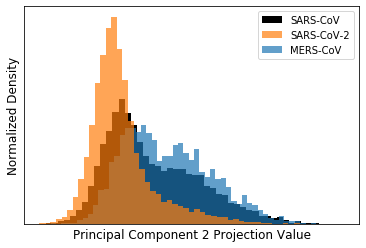

In [89]:
c = 1
fig, ax = plt.subplots()
_, _, _ = plt.hist(transformed[sars_article_indexes, c]
         , density=True, alpha=1., bins=50, label='SARS-CoV', color='black')
_, _, _ = plt.hist(transformed[covid_article_indexes, c], density=True,
                   alpha=0.7, bins=50, label='SARS-CoV-2', zorder=20, color='tab:orange')
_, _, _ = plt.hist(transformed[mers_article_indexes, c]
         , density=True, alpha=.7, bins=50, label='MERS-CoV', color='tab:blue') 
#     plt.title('Distribution of Articles on Principal Component ' + str(c + 1), size=14)
plt.xticks([]); plt.yticks([])
plt.ylabel('Normalized Density', size=12)
plt.xlabel('Principal Component ' + str(c + 1) + ' Projection Value', size=12)

plt.legend()
plt.savefig('Paper/Figures/2.png', dpi=dpi)
plt.show()

## Analysis

In [20]:
def get_top_words_and_scores(svd, dictionary, c, n, visual=True):
    word_ids_sorted = np.argsort(np.abs(svd.components_[c]))[::-1]
    top_words_and_scores = [[dictionary[word_ids_sorted[i]], svd.components_[c, word_ids_sorted[i]]] for i in range(n)]
    top_words_and_scores = pd.DataFrame(
        top_words_and_scores,columns=['word', 'component_score']).sort_values('component_score')
    
    if visual:
        %matplotlib inline
        %matplotlib inline

        fig, ax = plt.subplots(figsize=(18,6.5))
        plt.bar(height=top_words_and_scores['component_score'], x=top_words_and_scores['word'])
        plt.xticks(rotation=90, size=14)
        plt.xlabel("Lemmatized Term", size=16)
        plt.ylabel("Component " + str(c + 1) + ' Value', size=16)
#         plt.title("Top " + str(n) + " Words' Values of Principal Component " + str(c+1), size=20)
        plt.gcf().subplots_adjust(bottom=0.375) # without this, xlabel is cut off when fig is saved
    
    
        return top_words_and_scores, fig, ax
    else:
        return top_words_and_scores

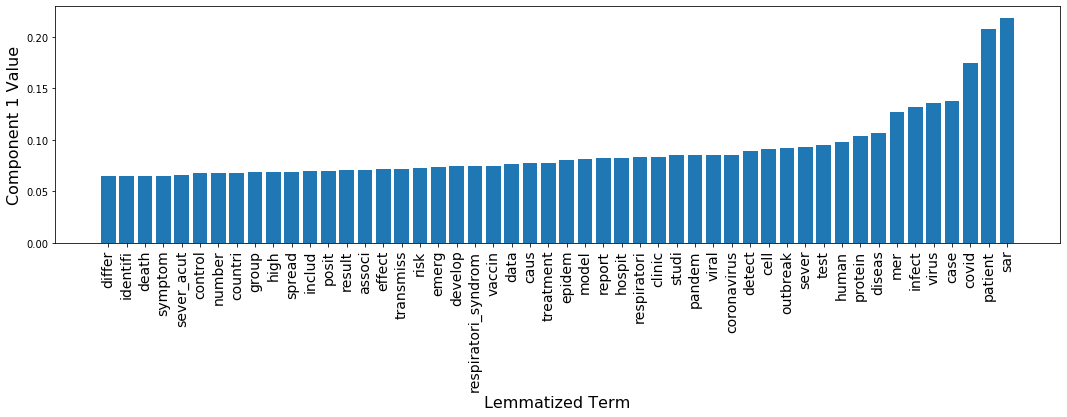

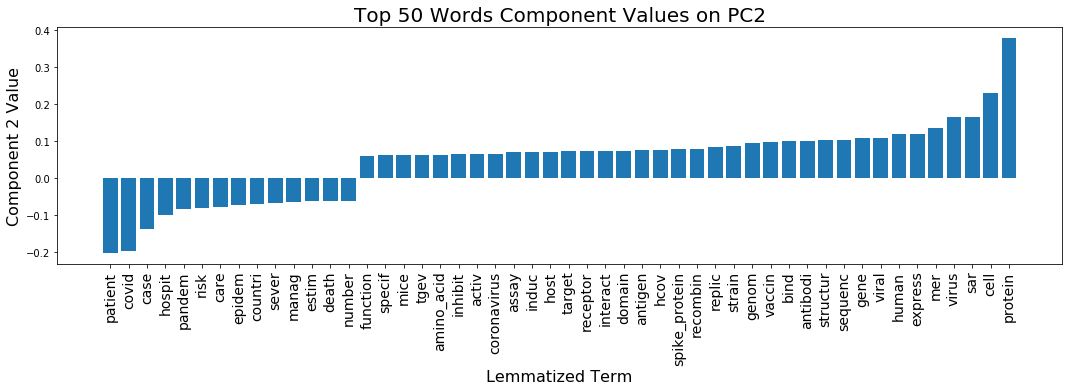

In [21]:
panel_lst = ['a', 'b']; panel_cnt = 0
panel_set = [
    [0.025, 0.95, 'A'],
    [0.025, 0.95, 'B']
]
    
for i in range(10):
    top_words_and_scores, fig, ax = get_top_words_and_scores(truncatedsvd, dictionary, i, 50, visual=True)
    if i in [c_0, c_1]:
#         plt.text(panel_set[panel_cnt][0], panel_set[panel_cnt][1], panel_set[panel_cnt][2],
#              transform=ax.transAxes, fontsize=28, fontweight='bold', va='top')
#         fig.savefig('Paper/Figures/4' + panel_lst[panel_cnt] +  '.png', dpi=dpi)
        plt.title('Top 50 Words Component Values on PC' + str(i + 1), size=20)
        fig.savefig('Paper/Figures/3' + '.png', dpi=dpi)
        panel_cnt += 1
        break
    plt.show()

In [22]:
c_a, c_b = c_0, c_1

metadata['component_a'] = transformed[:,c_0] * 10**6
metadata['component_b'] = transformed[:,c_1] * 10**6

metadata['component_a_percentile'] = metadata['component_a'].rank(pct=True)
metadata['component_b_percentile'] = metadata['component_b'].rank(pct=True)

In [23]:
metadata['abstract_COVID'] = metadata['abstract'].str.contains('COVID')

Word analysis

In [22]:
covid_or_not = False
word = 'spike protein'

total = sum(metadata['abstract_COVID'] == covid_or_not)
total_subset = sum((metadata['abstract_COVID'] == covid_or_not) & (metadata['abstract'].str.lower().str.contains(word)))
print(total_subset / total)

0.04200760931880961


Automated word analysis including bigrams

In [24]:
c = c_0
total_covid = sum(metadata['abstract_COVID'] == True)
total_not_covid = sum(metadata['abstract_COVID'] == False)
word_analysis_df = copy.deepcopy(metadata[['abstract_COVID']])


word_list = get_top_words_and_scores(truncatedsvd, dictionary, c, 50, visual=False)
covid_pcts = []; not_covid_pcts = []
for word in word_list['word']:
    word_analysis_df['contains_word'] = [word in doc for doc in preprocessor.preprocessed_text_]

    total_subset = sum((word_analysis_df['abstract_COVID']) & (word_analysis_df['contains_word'] ))
    covid_pcts.append(round(total_subset / total_covid * 100, 1))
    total_subset = sum((word_analysis_df['abstract_COVID'] == False) & (word_analysis_df['contains_word'] ))
    not_covid_pcts.append(round(total_subset / total_not_covid * 100, 1))
    
word_analysis = pd.DataFrame(np.array([word_list['word'], word_list['component_score'], covid_pcts, not_covid_pcts]).T, 
                             columns = ['word', 'component_' + str(c + 1) + '_score','covid_pcts', 'not_covid_pcts'])
word_analysis
word_analysis.to_csv('big_data/top-word-analysis-pc2.csv', index=False)

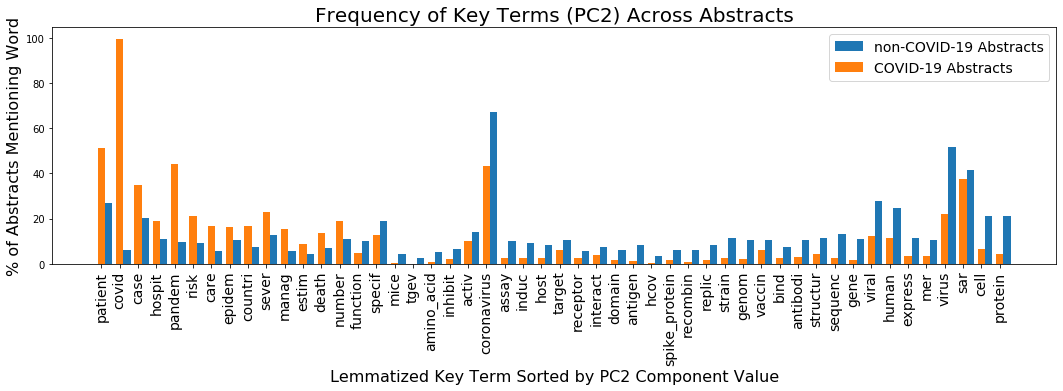

In [94]:
panel = 'A'

fig, ax = plt.subplots(figsize=(18,6.5))
plt.bar(np.arange(len(word_analysis['word'])) + 0.4,
        word_analysis['not_covid_pcts'], 
        label='non-COVID-19 Abstracts', width=0.4)
plt.bar(np.arange(len(word_analysis['word'])),
        word_analysis['covid_pcts'], 
        label='COVID-19 Abstracts', width=0.4)
plt.xticks(np.arange(len(word_analysis['word'])), word_analysis['word'], rotation=90, size=14)
plt.xlabel('Lemmatized Key Term Sorted by PC' + str(c + 1) +  ' Component Value', size=16)
plt.ylabel('% of Abstracts Mentioning Word', size=16)
plt.title('Frequency of Key Terms (PC' + str(c + 1) + ') Across Abstracts', size=20)
plt.legend(fontsize=14, loc='upper right')
plt.gcf().subplots_adjust(bottom=0.375)
# plt.text(0.0125, 0.95, panel, transform=ax.transAxes, fontsize=28, fontweight='bold', va='top')
fig.savefig('Paper/Figures/4.png', dpi=dpi)
# fig.savefig('Paper/Figures/5' + '.png', dpi=dpi)
plt.show()

Analysis of abstracts over time

In [25]:
metadata_dt_analysis = copy.deepcopy(metadata)

metadata_dt_analysis['converted_datetime'] = pd.to_datetime(metadata_dt_analysis['publish_time'], errors='coerce') # if format fails to parse, return NaT
metadata_dt_analysis = metadata_dt_analysis.sort_values('converted_datetime')
metadata_dt_analysis = metadata_dt_analysis[pd.isnull(metadata_dt_analysis['converted_datetime']) == False] # drop abstracts w/ null
metadata_dt_analysis = metadata_dt_analysis[metadata_dt_analysis['converted_datetime'] <= data_datetime] # drop those with impossible datetimes

In [26]:
# Key problems:
    # 2020 date times (~250 articles)
    # A couple of articles with no date time
    # A couple of articles with impossible date times

covid_abstracts = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
covid_abstracts = covid_abstracts[covid_abstracts['converted_datetime'] > 
                                 datetime.datetime(2020, 1, 1)] # drop those with only '2020' as datetime

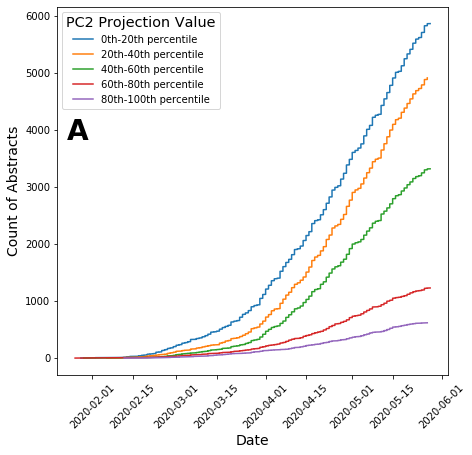

In [28]:
c = 1
c_all = [c_0, c_1]; c_index = np.argwhere(c == np.array(c_all)).T[0][0]
panel_key = ['a', 'b']
panel = panel_key[c_index]

fig, ax = plt.subplots(figsize=(7, 7))
covid_normalizer_df = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']] # use this to normalize cumsums for abstracts with just 2020 as date
for lower in np.array(list(range(5))) / 10 * 2:
    upper = lower + 0.2
    boolean = np.logical_and(covid_abstracts['component_' + panel + '_percentile'] >= lower, 
                                            covid_abstracts['component_' + panel + '_percentile'] <= upper)
    normalize_boolean = np.logical_and(covid_normalizer_df['component_' + panel + '_percentile'] >= lower, 
                                            covid_normalizer_df['component_' + panel + '_percentile'] <= upper)
    norm_factor = np.sum(normalize_boolean) / np.sum(boolean)
    plt.plot(covid_abstracts[boolean]['converted_datetime'],
             np.cumsum(np.repeat(1, len(covid_abstracts[boolean]))) * norm_factor,
             label=str(int(lower*100)) + 'th-' + str(int(upper*100)) + 'th percentile'
            )


plt.xticks(rotation=45)
plt.xlabel('Date', size=14)
plt.ylabel('Count of Abstracts', size=14)
# plt.title('Release of COVID-19 Abstracts Over Time (PC3)', size=18)
# plt.yscale('log')
legend = ax.legend(title='PC' + str(c + 1) + ' Projection Value')
plt.setp(legend.get_title(),fontsize='x-large')
plt.text(0.025, 0.70, panel.upper(), transform=ax.transAxes, fontsize=28, fontweight='bold', va='top')
plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('Paper/Figures/6' + panel +  '.png', dpi=dpi)
# fig.savefig('Paper/Figures/7'  +  '.png', dpi=dpi)
plt.show()

Tracking rxiv articles over time (not peer reviewed stuff)

Text(0.5, 1.0, 'COVID Articles')

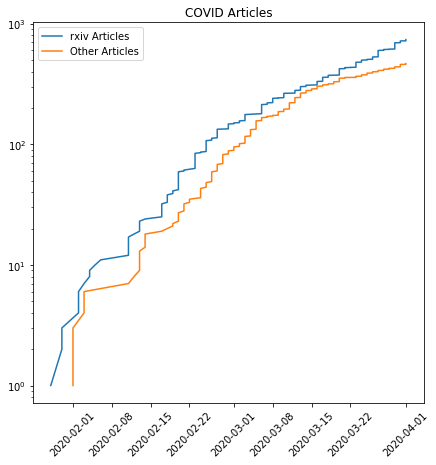

In [88]:
plt.figure(figsize=(7, 7))
boolean = covid_abstracts['source_x'].isin(['biorxiv', 'medrxiv'])
plt.plot(covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(covid_abstracts[boolean]))), label='rxiv Articles'
        )
boolean = boolean == False
plt.plot(covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(covid_abstracts[boolean]))), label='Other Articles'
        )

plt.xticks(rotation=45)
plt.yscale('log')
plt.legend()
plt.title('COVID Articles')

Text(0.5, 1.0, 'Non-COVID Articles')

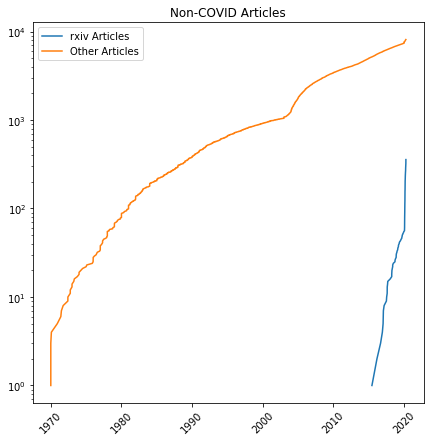

In [89]:
plt.figure(figsize=(7, 7))
non_covid_abstracts = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID'] == False]

boolean = non_covid_abstracts['source_x'].isin(['biorxiv', 'medrxiv'])
plt.plot(non_covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(non_covid_abstracts[boolean]))), label='rxiv Articles'
        )
boolean = boolean == False
plt.plot(non_covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(non_covid_abstracts[boolean]))), label='Other Articles'
        )

plt.xticks(rotation=45)
plt.yscale('log')
plt.legend()
plt.title('Non-COVID Articles')

# Write to file

In [40]:
metadata.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url', 'component_a',
       'component_b', 'component_a_percentile', 'component_b_percentile',
       'abstract_COVID'],
      dtype='object')

In [66]:
metadata_small = metadata[[
    'title', 'doi', 'pmcid', 'pubmed_id', 'abstract', 'publish_time', 'journal', 
    
    'component_a', 'component_b', 'component_a_percentile', 'component_b_percentile', 'abstract_COVID'
]]
metadata_small.to_csv('big_data/metadata_PCAed_subsetted', sep='|', index=False)

In [42]:
metadata_small

,title,doi,pmcid,pubmed_id,abstract,publish_time,journal,component_a,component_b,component_a_percentile,component_b_percentile,abstract_COVID
27,An ELISA for the detection of serum antibodies...,10.1016/0007-1935(91)90010-k,NaN,1717102.0,Abstract A competition ELISA utilizing a mAb d...,1991-08-31,British Veterinary Journal,14200.138057,-1691.775576,0.029722,0.620645,False
29,Equine arteritis virus: An overview,10.1016/0007-1935(92)90044-2,NaN,1319787.0,Abstract The causative agent of the respirator...,1992-06-30,British Veterinary Journal,24151.037390,-847.255219,0.461291,0.720755,False
33,Morphology and morphogenesis of a coronavirus ...,10.1016/0014-4800(76)90045-9,NaN,187445.0,Abstract The morphology and morphogenesis of v...,1976-12-31,Experimental and Molecular Pathology,14844.285255,-631.259247,0.037654,0.743850,False
37,Bovine coronavirus antigen in the host cell pl...,10.1016/0014-4800(90)90039-g,NaN,2261945.0,Abstract Expression of bovine coronavirus (BCV...,1990-10-31,Experimental and Molecular Pathology,23744.371183,-2334.723945,0.437393,0.544231,False
44,Endosomal association of a protein phosphatase...,10.1016/0014-5793(91)80528-b,NaN,1674698.0,Abstract On the assumption that dephosphorylat...,1991-05-06,FEBS Letters,18611.410004,406.048850,0.148107,0.835927,False
45,Putative papain-related thiol proteases of pos...,10.1016/0014-5793(91)81034-6,NaN,1652473.0,Abstract A computer-assisted comparative analy...,1991-08-19,FEBS Letters,24843.628572,321.154839,0.502761,0.828898,False
51,Influence of coronavirus (transmissible gastro...,10.1016/0016-5085(84)90717-0,NaN,6735081.0,Abstract Four silver—silver chloride electrode...,1984-08-31,Gastroenterology,16989.238183,-937.905451,0.087559,0.709509,False
57,An in-depth study of Crohn's disease in two Fr...,10.1016/0016-5085(93)90401-w,NaN,8425677.0,Abstract Background: Two French families were ...,1993-02-28,Gastroenterology,20415.724289,-2054.685672,0.239381,0.575459,False
67,The pathogenesis of nephritis in chickens indu...,10.1016/0021-9975(82)90078-0,NaN,6282945.0,Abstract Nephritis in chickens caused by infec...,1982-04-30,Journal of Comparative Pathology,17224.814409,-734.085184,0.094789,0.732001,False
76,Pathogenicity and antigen detection of the Nou...,10.1016/0021-9975(92)90068-6,NaN,1313460.0,Abstract We compared the pathogenicity and the...,1992-01-31,Journal of Comparative Pathology,14886.477126,196.798081,0.038558,0.819460,False
